# Binary Classification

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mental_health_subreddits_dataset.csv')

In [36]:
df.dropna(axis = 0, how = 'any')

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,This. Plus remember the poster in here a few w...,-0.6652
1,967,anxiety,1635203988,Currently 8 and a half months pregnant and als...,-0.8555
2,1142,anxiety,1635203613,Few people had COVID in my building and refuse...,-0.2960
3,1403,covid19_support,1635202948,My friend will be so relieved she didn't actua...,0.7626
4,1616,depression,1635202459,This hits close to home. \n\nHe sounds similar...,-0.4006
...,...,...,...,...,...
45879,17777050,anxiety,1581473713,"It is quite interesting, in terms of somewhat ...",-0.9256
45880,17777094,anxiety,1581466598,Stay focused on what the experts are saying an...,0.7430
45881,17777113,anxiety,1581463547,"No new COVID-19 cases in B.C., 4 confirmed pat...",-0.1531
45882,17777197,mentalhealth,1581454025,"Hi mate, as someone with GAD I can relate to y...",0.5332


In [3]:
df.tail()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
45879,17777050,anxiety,1581473713,"It is quite interesting, in terms of somewhat ...",-0.9256
45880,17777094,anxiety,1581466598,Stay focused on what the experts are saying an...,0.7430
45881,17777113,anxiety,1581463547,"No new COVID-19 cases in B.C., 4 confirmed pat...",-0.1531
45882,17777197,mentalhealth,1581454025,"Hi mate, as someone with GAD I can relate to y...",0.5332
45883,17777368,anxiety,1581071322,***MORE UPDATES ON MY OTHER COMMENT ON THIS T...,0.9325


In [77]:
import re #regex library used for substituting words
import demoji #https://github.com/bsolomon1124/demoji
# demoji.download_codes()

In [78]:
def pre_cleaning(text):
    line=re.sub(r"\Bu/\w+", "USERNAME", text) #replace username with USERNAME
    line = demoji.replace(line, repl=' ')
    return line

In [79]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [80]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [81]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [82]:
df.body = df.body.apply(lambda x: preprocessing(x))

### Anxiety SVM

In [83]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'anxiety':
        drop_list.append(a)

In [84]:
anxiety_sample = df.drop(drop_list, axis = 0)
anxiety_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
1,967,anxiety,1635203988,currently half months pregnant also covid suff...,-0.8555
2,1142,anxiety,1635203613,people covid building refused get vaccinated,-0.2960
7,5439,anxiety,1635193321,surrounded anti covid vax people mine also sec...,-0.9364
8,5753,anxiety,1635192653,wow found sub reddit today really ever reddit ...,-0.9878
12,7513,anxiety,1635188671,fine study results shown amp plus moderna comb...,0.9834
...,...,...,...,...,...
45878,17777040,anxiety,1581474617,interesting indeed also interesting much menta...,0.9428
45879,17777050,anxiety,1581473713,quite interesting terms somewhat putting thing...,-0.9256
45880,17777094,anxiety,1581466598,stay focused experts saying avoid sensationali...,0.7430
45881,17777113,anxiety,1581463547,new covid cases c confirmed patients well prov...,-0.1531


In [85]:
for sentiment in anxiety_sample['sentiment']:
    anxiety_sample['sentiment'].replace({sentiment : 'anxiety'}, inplace=True)

In [86]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'anxiety':
        control_list.append(a)

In [87]:
anxiety_control = df.drop(control_list, axis = 0)
anxiety_control = anxiety_control.sample(16689)
anxiety_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
38866,15757713,depression,1590029702,struggle similar issues end get better life li...,-0.3444
39388,15910298,covid19_support,1589493205,covid lethal led believe,0.0000
8875,5230812,covid19_support,1621608996,accurate generalization someone tried combat a...,0.6361
14044,7701391,covid19_support,1614004863,millions people covid recovered without lastin...,0.5489
16384,8653058,mentalhealth,1611094408,mom passed teenager father made everyones life...,-0.9553
...,...,...,...,...,...
20570,10181292,depression,1607054151,listen man know probably wont mean much since ...,0.9834
1870,1172795,depression,1632100057,hard many students especially covid alone feel...,0.3549
18060,9251389,covid19_support,1609496153,best resources looking someone home tl dr try ...,0.9542
15412,8259857,depression,1612242689,appreciate one friend mad hang much anymore bf...,-0.5267


In [88]:
for sentiment in anxiety_control['sentiment']:
    anxiety_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [89]:
anxiety_dataset = pd.concat([anxiety_sample, anxiety_control])
anxiety_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
1,967,anxiety,1635203988,currently half months pregnant also covid suff...,anxiety
2,1142,anxiety,1635203613,people covid building refused get vaccinated,anxiety
7,5439,anxiety,1635193321,surrounded anti covid vax people mine also sec...,anxiety
8,5753,anxiety,1635192653,wow found sub reddit today really ever reddit ...,anxiety
12,7513,anxiety,1635188671,fine study results shown amp plus moderna comb...,anxiety
...,...,...,...,...,...
20570,10181292,depression,1607054151,listen man know probably wont mean much since ...,control
1870,1172795,depression,1632100057,hard many students especially covid alone feel...,control
18060,9251389,covid19_support,1609496153,best resources looking someone home tl dr try ...,control
15412,8259857,depression,1612242689,appreciate one friend mad hang much anymore bf...,control


In [90]:
from sklearn.model_selection import train_test_split

In [91]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(anxiety_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 26702
Test Data size 6676


In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [94]:
print("anxiety_train Shape:",x_train.shape)
print("anxiety_test Shape:",x_test.shape)

anxiety_train Shape: (26702, 11375)
anxiety_test Shape: (6676, 11375)


In [95]:
from sklearn.preprocessing import LabelEncoder

In [96]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (26702, 1)
y_test shape: (6676, 1)


In [97]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics

In [98]:
# Perform classification with SVM, kernel=linear
anxiety_classifier = svm.SVC(kernel='linear')
t0 = time.time()
anxiety_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = anxiety_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'anxiety']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('anxiety: ', report['anxiety'])

Training time: 405.514172s; Prediction time: 49.972994s
Accuracy: 0.78070701018574
control:  {'precision': 0.8250768705158865, 'recall': 0.7172557172557172, 'f1-score': 0.767397521448999, 'support': 3367}
anxiety:  {'precision': 0.7460656174979995, 'recall': 0.8452704744635842, 'f1-score': 0.7925758005100594, 'support': 3309}


### Depression SVM

In [99]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'depression':
        drop_list.append(a)

In [100]:
depression_sample = df.drop(drop_list, axis = 0)
depression_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
4,1616,depression,1635202459,hits close home sounds similar pour insight th...,-0.4006
6,5124,depression,1635194028,sorry dog amp going parents also think covid h...,-0.6387
43,25236,depression,1635130949,hey man care feel dealing since 17 sucks days ...,-0.3371
44,25409,depression,1635130321,everything life moving forward need surrounded...,0.4323
63,37410,depression,1635096893,makes basically like nasty cold get covid vacc...,-0.5106
...,...,...,...,...,...
45591,17714315,depression,1583509183,hospital crowded covid panic missing hour gues...,-0.5719
45654,17730423,depression,1583294463,first confirmed case covid state today low key...,-0.9345
45655,17730635,depression,1583291007,covid coming worries bro,0.3252
45779,17766846,depression,1582518347,advice talk recruiter biochem degree probably ...,0.0000


In [101]:
for sentiment in depression_sample['sentiment']:
    depression_sample['sentiment'].replace({sentiment : 'depression'}, inplace=True)

In [102]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'depression':
        control_list.append(a)

In [103]:
depression_control = df.drop(control_list, axis = 0)
depression_control = depression_control.sample(5871)
depression_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
30419,13427175,anxiety,1597451126,post removed flagged see mentioned covid pleas...,0.7635
8560,5095243,covid19_support,1622087034,absolutely concern unvaccinated look unvaccina...,0.0000
24432,11596588,covid19_support,1603225360,great doctor know 2l per day good people keep ...,0.9697
6855,4246070,anxiety,1625436271,exact fears etmetophobic also trauma related n...,0.9536
22212,10785028,anxiety,1605532994,clarify get tested positive covid never admitt...,0.0977
...,...,...,...,...,...
28632,12956491,mentalhealth,1599000333,hi sorry hear situation thank sharing would as...,0.8270
13391,7417511,covid19_support,1614880111,florida grade data completedness covid trackin...,-0.2382
40267,16153078,covid19_support,1588657387,covid severe asthmatic pneumonia august year c...,0.9530
10330,5987596,mentalhealth,1619373760,true covid exactly help job market hopefully s...,0.8461


In [104]:
for sentiment in depression_control['sentiment']:
    depression_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [105]:
depression_dataset = pd.concat([depression_sample, depression_control])
depression_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
4,1616,depression,1635202459,hits close home sounds similar pour insight th...,depression
6,5124,depression,1635194028,sorry dog amp going parents also think covid h...,depression
43,25236,depression,1635130949,hey man care feel dealing since 17 sucks days ...,depression
44,25409,depression,1635130321,everything life moving forward need surrounded...,depression
63,37410,depression,1635096893,makes basically like nasty cold get covid vacc...,depression
...,...,...,...,...,...
28632,12956491,mentalhealth,1599000333,hi sorry hear situation thank sharing would as...,control
13391,7417511,covid19_support,1614880111,florida grade data completedness covid trackin...,control
40267,16153078,covid19_support,1588657387,covid severe asthmatic pneumonia august year c...,control
10330,5987596,mentalhealth,1619373760,true covid exactly help job market hopefully s...,control


In [106]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(depression_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 9393
Test Data size 2349


In [107]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [108]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (9393, 6635)
x_test Shape: (2349, 6635)


In [109]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (9393, 1)
y_test shape: (2349, 1)


In [110]:
# Perform classification with SVM, kernel=linear
depression_classifier = svm.SVC(kernel='linear')
t0 = time.time()
depression_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = depression_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'depression']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('depression: ', report['depression'])

Training time: 29.031493s; Prediction time: 6.250706s
Accuracy: 0.7777777777777778
control:  {'precision': 0.8109161793372319, 'recall': 0.7172413793103448, 'f1-score': 0.7612076852698992, 'support': 1160}
depression:  {'precision': 0.7520786092214664, 'recall': 0.8368376787216149, 'f1-score': 0.7921974522292995, 'support': 1189}


### MentalHealth SVM

In [33]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'mentalhealth':
        drop_list.append(a)

In [34]:
mentalhealth_sample = df.drop(drop_list, axis = 0)
mentalhealth_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
9,6594,mentalhealth,1635190779,"Covid, I have to be with my girlfriend at home...",0.1615
13,8232,mentalhealth,1635187037,I'm like this. My company made all of us work ...,0.7631
27,13991,mentalhealth,1635174447,"Not to sound egotistical, but I used to have t...",0.8508
29,16648,mentalhealth,1635167578,"95, that’s a really good age. Accept her decis...",0.9847
31,16902,mentalhealth,1635166737,Hey I’m sorry you’re going through a tough tim...,0.9747
...,...,...,...,...,...
45301,17612619,mentalhealth,1584120252,You’re right to worry about this. I’m worried ...,-0.9284
45323,17622751,mentalhealth,1584086361,Don't watch TV or search for covid info online,0.0000
45331,17624677,mentalhealth,1584077134,I’m sorry to hear your anxieties are acting up...,-0.9574
45441,17670621,mentalhealth,1583895477,You don't need to worry. \n\nYou should take a...,0.9730


In [35]:
for sentiment in mentalhealth_sample['sentiment']:
    mentalhealth_sample['sentiment'].replace({sentiment : 'mentalhealth'}, inplace=True)

In [37]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'mentalhealth':
        control_list.append(a)

In [38]:
mentalhealth_control = df.drop(control_list, axis = 0)
mentalhealth_control = mentalhealth_control.sample(3307)
mentalhealth_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
23314,11198606,depression,1604365075,No it's not. People have busy lifes. And COVID...,-0.5472
23052,11095123,covid19_support,1604678943,But how. \n\nIt can't when I don't have a part...,-0.9664
38212,15575955,anxiety,1590695858,103-year-old Massachusetts woman beats coronav...,0.9610
25490,11977268,anxiety,1602055647,Your post has **not** been removed or flagged....,0.7635
26433,12330415,anxiety,1601090803,The racing thoughts that I have are hard to de...,0.9899
...,...,...,...,...,...
32859,14124456,depression,1595466738,"Yah, friendships mature with age. When I was 1...",0.9056
35758,14947609,covid19_support,1593107699,Contact both your town and state public health...,-0.8949
33055,14179664,depression,1595312371,I’m terribly sorry you feel this way. I feel s...,0.1546
10,6751,covid19_support,1635190382,I’m wondering this too. Held off on the vaccin...,0.5122


In [39]:
for sentiment in mentalhealth_control['sentiment']:
    mentalhealth_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [40]:
mentalhealth_dataset = pd.concat([mentalhealth_sample, mentalhealth_control])
mentalhealth_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
9,6594,mentalhealth,1635190779,"Covid, I have to be with my girlfriend at home...",mentalhealth
13,8232,mentalhealth,1635187037,I'm like this. My company made all of us work ...,mentalhealth
27,13991,mentalhealth,1635174447,"Not to sound egotistical, but I used to have t...",mentalhealth
29,16648,mentalhealth,1635167578,"95, that’s a really good age. Accept her decis...",mentalhealth
31,16902,mentalhealth,1635166737,Hey I’m sorry you’re going through a tough tim...,mentalhealth
...,...,...,...,...,...
32859,14124456,depression,1595466738,"Yah, friendships mature with age. When I was 1...",control
35758,14947609,covid19_support,1593107699,Contact both your town and state public health...,control
33055,14179664,depression,1595312371,I’m terribly sorry you feel this way. I feel s...,control
10,6751,covid19_support,1635190382,I’m wondering this too. Held off on the vaccin...,control


In [41]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(mentalhealth_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 5291
Test Data size 1323


In [42]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [43]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (5291, 5449)
x_test Shape: (1323, 5449)


In [44]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (5291, 1)
y_test shape: (1323, 1)


In [45]:
# Perform classification with SVM, kernel=linear
mentalhealth_classifier = svm.SVC(kernel='linear')
t0 = time.time()
mentalhealth_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = mentalhealth_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'mentalhealth']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('mentalhealth: ', report['mentalhealth'])

Training time: 12.495089s; Prediction time: 2.831244s
Accuracy: 0.7256235827664399
control:  {'precision': 0.7431506849315068, 'recall': 0.6707882534775889, 'f1-score': 0.7051177904142973, 'support': 647}
mentalhealth:  {'precision': 0.7117726657645467, 'recall': 0.7781065088757396, 'f1-score': 0.7434628975265017, 'support': 676}


### SuicideWatch SVM

In [46]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'suicidewatch':
        drop_list.append(a)

In [47]:
SuicideWatch_sample = df.drop(drop_list, axis = 0)
SuicideWatch_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16,9252,suicidewatch,1635184847,I am sorry to hear this. I also kind of blame ...,0.0534
33,18264,suicidewatch,1635161963,"Yeah, the way things are, the COVID age, it fu...",-0.9579
36,21384,suicidewatch,1635146582,When its your final exams you'll right it can....,0.9455
38,22331,suicidewatch,1635141823,U sound worn out. A few bad exams aren’t going...,-0.9260
39,22499,suicidewatch,1635141016,There are limitless options for you including ...,0.8519
...,...,...,...,...,...
45543,17698755,suicidewatch,1583683763,"Of course and, COVID-19 shouldn’t be downplaye...",0.8612
45576,17706874,suicidewatch,1583592020,"Yes, to bolster what you thought and what u/Qu...",-0.1513
45651,17729169,suicidewatch,1583321376,At this point in time I think that talking is ...,0.7411
45722,17743055,suicidewatch,1583101515,For now. Chances of getting it should pick up ...,-0.9186


In [48]:
for sentiment in SuicideWatch_sample['sentiment']:
     SuicideWatch_sample['sentiment'].replace({sentiment : 'suicidewatch'}, inplace=True)

In [49]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'suicidewatch':
        control_list.append(a)

In [50]:
SuicideWatch_control = df.drop(control_list, axis = 0)
SuicideWatch_control = SuicideWatch_control.sample(4049)
SuicideWatch_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16722,8766984,mentalhealth,1610757421,I feel this way all the time! Im turning 20 an...,0.9793
25095,11815393,anxiety,1602531097,I've been an emetophobe since I was around 3yo...,-0.8858
32784,14104799,covid19_support,1595528961,I can’t really answer that because I am not an...,0.4821
24092,11498657,depression,1603537630,"Depressed, anxious, lost my job twice this yea...",-0.4005
29737,13262475,depression,1597984100,Maybe try to join so Meetup groups? Or volunte...,0.8732
...,...,...,...,...,...
6152,3815989,covid19_support,1626814667,nono it's done well but I simply dont understa...,0.4975
14927,8065070,depression,1612831762,"Hey I hear you, I’ve been there. A couple thin...",0.8030
27410,12619289,mentalhealth,1600116203,"Hi, I haven’t been diagnosed with bipolar but ...",0.9083
36642,15196692,anxiety,1592200314,"I'm terrified of that too- unknown, unpredicta...",0.8425


In [51]:
for sentiment in SuicideWatch_control['sentiment']:
    SuicideWatch_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [52]:
SuicideWatch_dataset = pd.concat([SuicideWatch_sample, SuicideWatch_control])
SuicideWatch_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
16,9252,suicidewatch,1635184847,I am sorry to hear this. I also kind of blame ...,suicidewatch
33,18264,suicidewatch,1635161963,"Yeah, the way things are, the COVID age, it fu...",suicidewatch
36,21384,suicidewatch,1635146582,When its your final exams you'll right it can....,suicidewatch
38,22331,suicidewatch,1635141823,U sound worn out. A few bad exams aren’t going...,suicidewatch
39,22499,suicidewatch,1635141016,There are limitless options for you including ...,suicidewatch
...,...,...,...,...,...
6152,3815989,covid19_support,1626814667,nono it's done well but I simply dont understa...,control
14927,8065070,depression,1612831762,"Hey I hear you, I’ve been there. A couple thin...",control
27410,12619289,mentalhealth,1600116203,"Hi, I haven’t been diagnosed with bipolar but ...",control
36642,15196692,anxiety,1592200314,"I'm terrified of that too- unknown, unpredicta...",control


In [53]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(SuicideWatch_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 6478
Test Data size 1620


In [54]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [55]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (6478, 5623)
x_test Shape: (1620, 5623)


In [56]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (6478, 1)
y_test shape: (1620, 1)


In [57]:
# Perform classification with SVM, kernel=linear
suicidewatch_classifier = svm.SVC(kernel='linear')
t0 = time.time()
suicidewatch_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = suicidewatch_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'suicidewatch']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('suicidewatch: ', report['suicidewatch'])

Training time: 15.314466s; Prediction time: 3.436201s
Accuracy: 0.762962962962963
control:  {'precision': 0.799405646359584, 'recall': 0.6836086404066074, 'f1-score': 0.7369863013698631, 'support': 787}
suicidewatch:  {'precision': 0.737064413938754, 'recall': 0.8379351740696278, 'f1-score': 0.7842696629213483, 'support': 833}


### COVID19_support SVM

In [58]:
drop_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] != 'covid19_support':
        drop_list.append(a)

In [59]:
COVID19_support_sample = df.drop(drop_list, axis = 0)
COVID19_support_sample

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,This. Plus remember the poster in here a few w...,-0.6652
3,1403,covid19_support,1635202948,My friend will be so relieved she didn't actua...,0.7626
5,4886,covid19_support,1635194581,This is a good overview article:\n\nhttps://ww...,0.4404
10,6751,covid19_support,1635190382,I’m wondering this too. Held off on the vaccin...,0.5122
11,6861,covid19_support,1635190117,Hi there - hope you are on the mend soon!!\n\n...,-0.8652
...,...,...,...,...,...
45759,17760404,covid19_support,1582754661,"I am crying, thank you so much for the kind an...",0.9465
45789,17767975,covid19_support,1582448772,You're going to be fine. It's highly unlikely ...,0.6369
45833,17772941,covid19_support,1581974557,"No worries, I'm pretty busy myself. Mostly wit...",0.6738
45849,17773901,covid19_support,1581865627,https://www.xjtlu.edu.cn/en/news/2020/02/mode...,0.1868


In [60]:
for sentiment in COVID19_support_sample['sentiment']:
    COVID19_support_sample['sentiment'].replace({sentiment : 'covid19_support'}, inplace=True)

In [61]:
control_list = []
for a in range(45884):
    if df.at[a, 'subreddit.name'] == 'covid19_support':
        control_list.append(a)

COVID19_support_control = df.drop(control_list, axis = 0)
COVID19_support_control = COVID19_support_control.sample(15968)
COVID19_support_control

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
22322,10824084,depression,1605424696,This covid shit sucks I have no drive to do an...,-0.8679
21943,10679254,depression,1605754908,only thing that kinda helped me with libido is...,0.5247
17563,9058007,mentalhealth,1609961597,"what does ""ADD ND"" and ""AFAB"" stand for? New t...",0.8735
23121,11121289,anxiety,1604598582,"I think normalizing masks is a good thing, esp...",0.8847
25883,12116930,anxiety,1601737682,Your post has **not** been removed or flagged....,0.7635
...,...,...,...,...,...
16913,8842146,depression,1610564829,Maybe you have covid?,0.0000
5727,3538372,mentalhealth,1627494461,Have you tried online jobs or work from home? ...,0.7804
4562,2919351,anxiety,1628733158,"I won't sugarcoat, I thought I had covid and t...",-0.7077
25941,12154502,depression,1601656339,I wish COVID had killed me,-0.4215


In [62]:
for sentiment in COVID19_support_control['sentiment']:
    COVID19_support_control['sentiment'].replace({sentiment : 'control'}, inplace=True)

In [63]:
COVID19_support_dataset = pd.concat([COVID19_support_sample, COVID19_support_control])
COVID19_support_dataset

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,This. Plus remember the poster in here a few w...,covid19_support
3,1403,covid19_support,1635202948,My friend will be so relieved she didn't actua...,covid19_support
5,4886,covid19_support,1635194581,This is a good overview article:\n\nhttps://ww...,covid19_support
10,6751,covid19_support,1635190382,I’m wondering this too. Held off on the vaccin...,covid19_support
11,6861,covid19_support,1635190117,Hi there - hope you are on the mend soon!!\n\n...,covid19_support
...,...,...,...,...,...
16913,8842146,depression,1610564829,Maybe you have covid?,control
5727,3538372,mentalhealth,1627494461,Have you tried online jobs or work from home? ...,control
4562,2919351,anxiety,1628733158,"I won't sugarcoat, I thought I had covid and t...",control
25941,12154502,depression,1601656339,I wish COVID had killed me,control


In [64]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(COVID19_support_dataset, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 25548
Test Data size 6388


In [65]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [66]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (25548, 11966)
x_test Shape: (6388, 11966)


In [67]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (25548, 1)
y_test shape: (6388, 1)


In [68]:
# Perform classification with SVM, kernel=linear
covid19_support_classifier = svm.SVC(kernel='linear')
t0 = time.time()
covid19_support_classifier.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = covid19_support_classifier.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0]
target_names = ['control', 'covid19_support']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('control: ', report['control'])
print('covid19_support: ', report['covid19_support'])

Training time: 477.406255s; Prediction time: 62.224908s
Accuracy: 0.7982154038822793
control:  {'precision': 0.7955056179775281, 'recall': 0.7916932907348243, 'f1-score': 0.7935948759007205, 'support': 3130}
covid19_support:  {'precision': 0.8007943782462572, 'recall': 0.8044812768569675, 'f1-score': 0.8026335936303781, 'support': 3258}


## Binary Classification Feature Importance

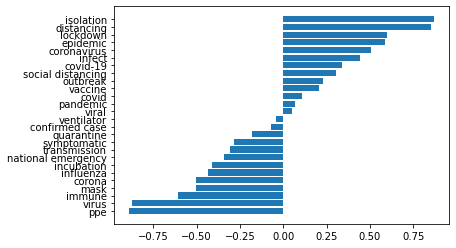

In [69]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['corona', 
                  'virus', 
                  'viral', 
                  'covid', 
                  'influenza', 
                  'pandemic', 
                  'epidemic', 
                  'quarantine', 
                  'lockdown',
                  'distancing', 
                  'national emergency', 
                  'infect', 
                  'ventilator', 
                  'mask', 
                  'symptomatic', 
                  'immune', 
                  'incubation', 
                  'transmission', 
                  'vaccine',
                  'confirmed case',
                  'coronavirus',
                  'covid-19',
                  'outbreak',
                  'ppe',
                  'isolation',
                  'social distancing' ]
f_importances(anxiety_classifier.coef_.toarray()[0], features_names)

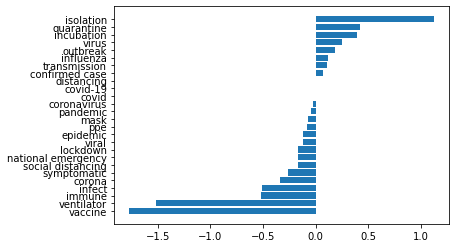

In [70]:
f_importances(depression_classifier.coef_.toarray()[0], features_names)

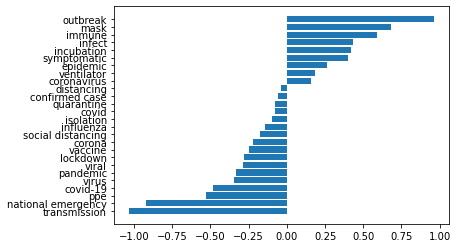

In [71]:
f_importances(mentalhealth_classifier.coef_.toarray()[0], features_names)

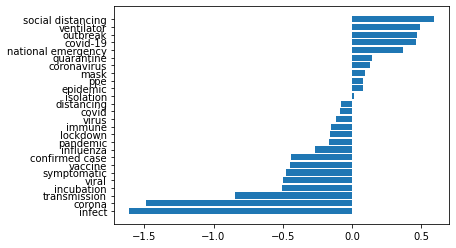

In [72]:
f_importances(suicidewatch_classifier.coef_.toarray()[0], features_names)

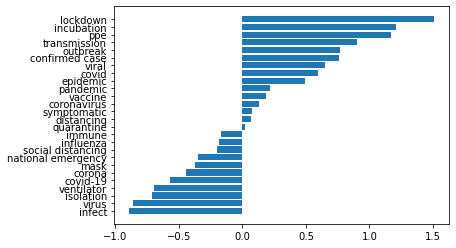

In [73]:
f_importances(covid19_support_classifier.coef_.toarray()[0], features_names)

In [75]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

38451


/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


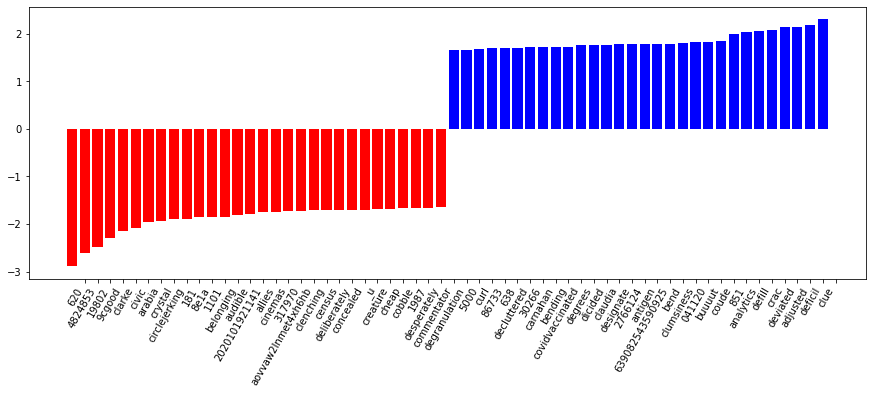

In [76]:
def plot_coefficients(classifier, feature_names, top_features=30):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
cv = CountVectorizer(stop_words = 'english')
cv.fit(train_data.body.to_list())
print (len(cv.vocabulary_))

svm = LinearSVC()
svm.fit(x_train, y_train)

plot_coefficients(svm, cv.get_feature_names())